In [13]:
# Import the required libraries.
import numpy as np
import cv2
import os
import random
import datetime as dt
import matplotlib.pyplot as plt
from collections import deque

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.python.ops.gen_nn_ops import MaxPool

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
!pwd

/content


# **Data Preprocessing**

In [4]:
!unzip /content/drive/MyDrive/Dataset_for_Training.zip

Archive:  /content/drive/MyDrive/Dataset_for_Training.zip
   creating: Dataset for Training/Explosion/
  inflating: Dataset for Training/Explosion/Explosion01.mp4  
  inflating: Dataset for Training/Explosion/Explosion02.mp4  
  inflating: Dataset for Training/Explosion/Explosion03.mp4  
  inflating: Dataset for Training/Explosion/Explosion04.mp4  
  inflating: Dataset for Training/Explosion/Explosion05.mp4  
  inflating: Dataset for Training/Explosion/Explosion06.mp4  
  inflating: Dataset for Training/Explosion/Explosion07.mp4  
  inflating: Dataset for Training/Explosion/Explosion08.mp4  
  inflating: Dataset for Training/Explosion/Explosion09.mp4  
  inflating: Dataset for Training/Explosion/Explosion10.mp4  
  inflating: Dataset for Training/Explosion/Explosion11.mp4  
  inflating: Dataset for Training/Explosion/Explosion12.mp4  
  inflating: Dataset for Training/Explosion/Explosion13.mp4  
  inflating: Dataset for Training/Explosion/Explosion14.mp4  
  inflating: Dataset for Trai

This is all_classes_names ['Fighting', 'Explosion', 'RoadAccidents']
This is random_range [2, 1, 0]
RoadAccidents
Roadaccidents02.mp4
Explosion
Explosion20.mp4
Fighting
Fighting58.mp4


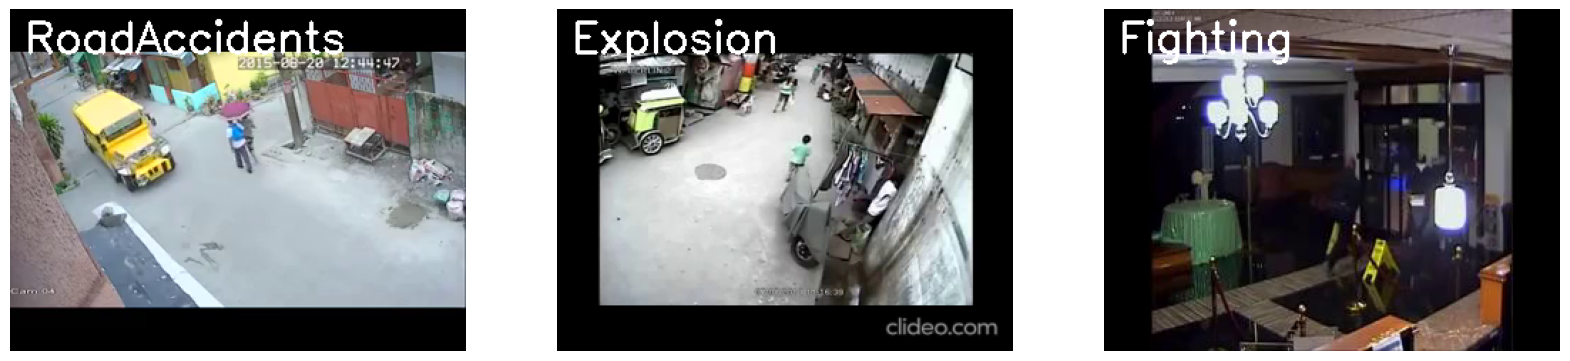

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir("Dataset_for_Training")
print("This is all_classes_names", all_classes_names)

# Generate a list of 3 random values. The values will be between 0-3,
# where 3 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 3)
print("This is random_range", random_range)

# Iterating through all the generated random values
for counter, random_index in enumerate(random_range, 1):

  # Retrieve a Class Name using the Random Index.
  selected_class_Name = all_classes_names[random_index]
  print(selected_class_Name)

  # Retrieve the list of all the video files present in the randomly selected Class Directory.
  video_files_names_list = os.listdir(f'Dataset_for_Training/{selected_class_Name}')

  # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
  selected_video_file_name = random.choice(video_files_names_list)
  print(selected_video_file_name)

  # Initialize a VideoCapture object to read from the video File.
  video_reader = cv2.VideoCapture(f'Dataset_for_Training/{selected_class_Name}/{selected_video_file_name}')

  # Read the first frame of the video file.
  _, bgr_frame = video_reader.read()

  # Release the videoCapure object
  video_reader.release()

  # Convert the frame from BGR into RGB format.
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame.
  cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  # Display the frame
  plt.subplot(1, 3, counter) ; plt.imshow(rgb_frame) ; plt.axis('off')

## Extract Dataset

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the dataset.
DATASET_DIR = "Dataset_for_Training"

CLASSES_LIST = ["Explosion", "Fighting", "RoadAccidents"]

In [7]:
def frames_extraction(video_path):
  """
  This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
  """

  # Declare a List to store video frames.
  frames_list = []

  # Read the video file using the videoCapture object
  video_reader = cv2.VideoCapture(video_path)

  # Get the total number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  #print(video_frames_count)

  # Calculate the the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  #print(skip_frames_window)

  # Iterate through the video Frames.
  for frame_counter in range(SEQUENCE_LENGTH):

    # Set the current frame position of the video.
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Reading the frame from the video.
    success, frame = video_reader.read()

    # Check if Video frame is not successfully read then break the loop
    if not success:
      break

    # Resize the Frame to fixed height and width
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    # Append the normalized frame into the frames list
    frames_list.append(normalized_frame)

  # Release the VideoCapture object.
  video_reader.release()

  # Return the frames list.
  return frames_list

In [8]:
frames_list = frames_extraction("/content/Dataset_for_Training/Explosion/Explosion01.mp4")

In [9]:
len(frames_list)

30

## **Create Dataset for Training**

In [10]:
def create_dataset():

  """
  This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
  """

  # Declared Empty Lists to store the features, labels and video file path values.
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):

    # Display the name of the class whose data is being extracted.
    print(f'Extraction Data of Class: {class_name}')

    # Get the list of video files present in the specific class name directory.
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    #print(files_list)

    for file_name in files_list:

      # Get the complete video path.
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      # Extract the frames of the video file.
      frames = frames_extraction(video_file_path)

      # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
      # So ignore the vides having frames less than the SEQUENCE_LENGTH.
      """if len(frames) != SEQUENCE_LENGTH:
        print(video_file_path, len(frames))
      """
      if len(frames) == SEQUENCE_LENGTH:

        # Append the data to their respective lists.
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # Converting the list to numpy arrays.
  features = np.asarray(features)
  labels = np.array(labels)

  # Return the frames, class index, and video file path.
  return features, labels, video_files_paths


In [11]:
# Create the dataset.
features, labels, video_file_paths = create_dataset()

Extraction Data of Class: Explosion
Extraction Data of Class: Fighting
Extraction Data of Class: RoadAccidents


In [14]:
print(features.shape, "\n",labels.shape, "\n", len(video_file_paths))

(191, 30, 64, 64, 3) 
 (191,) 
 191


In [15]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
# Using Keras to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [17]:
one_hot_encoded_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [18]:
# Split the Data into Train (85%) and Test Set (15%).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.18, shuffle = True)

In [19]:
features_test.shape

(35, 30, 64, 64, 3)

In [20]:
def create_convlstm_model():
  """
  This function will construct the required convlstm model.
  Returns:
    model: It is the required constructed convlstm model.
  """

  # We will use a Sequential model for model construction
  model = Sequential()

  # Define the Model Architecture.
  ########################################################################################################################

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = "tanh", data_format = "channels_last",
                       recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))



  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()

  return model

In [21]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 30, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 30, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 30, 15, 15, 8)     0         
 g3D)                                                            
                                                        

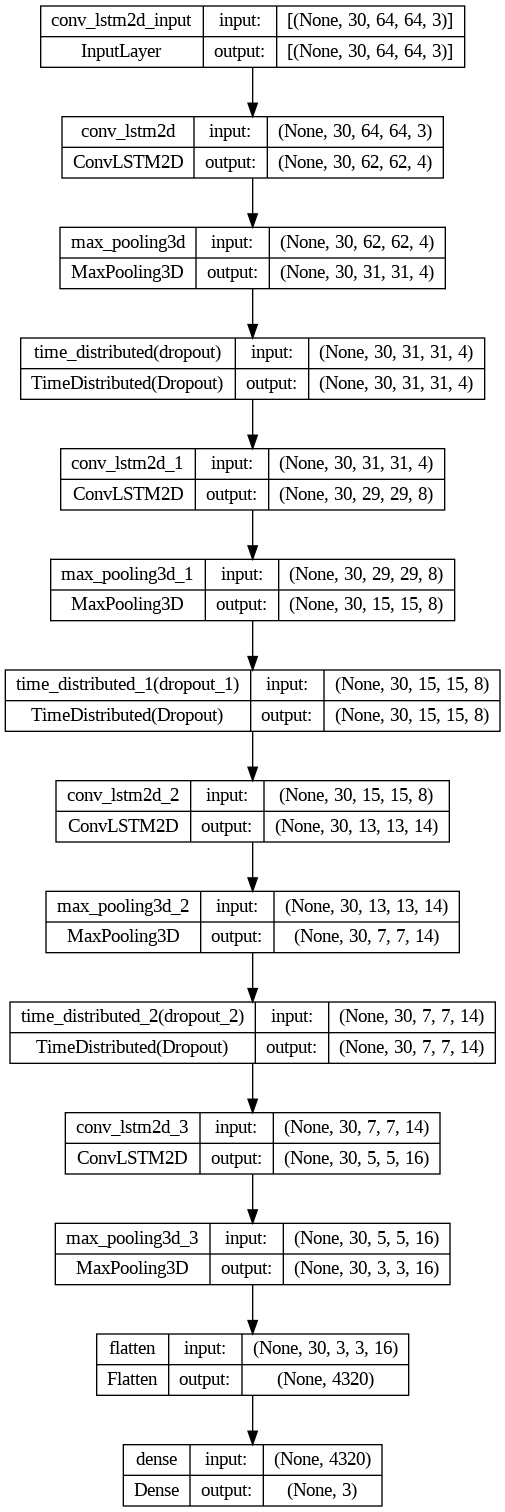

In [22]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [23]:
from sklearn.utils import validation
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 250, batch_size = 34,
                                                     shuffle = True,  validation_data = (features_test, labels_test))#, validation_split = 0.2)
                                                    # ,callbacks = [early_stopping_callback])

Epoch 1/250
5/5 [==============================] - 64s 11s/step - loss: 1.0980 - accuracy: 0.3526 - val_loss: 1.1456 - val_accuracy: 0.3429
Epoch 2/250
5/5 [==============================] - 55s 11s/step - loss: 1.0951 - accuracy: 0.3654 - val_loss: 1.1366 - val_accuracy: 0.2286
Epoch 3/250
5/5 [==============================] - 52s 10s/step - loss: 1.0760 - accuracy: 0.4038 - val_loss: 1.1096 - val_accuracy: 0.3429
Epoch 4/250
5/5 [==============================] - 52s 10s/step - loss: 1.0661 - accuracy: 0.4551 - val_loss: 1.1657 - val_accuracy: 0.2286
Epoch 5/250
1/5 [=====>........................] - ETA: 43s - loss: 0.9886 - accuracy: 0.5294

KeyboardInterrupt: ignored

In [24]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 [==============================] - 3s 286ms/step - loss: 1.2311 - accuracy: 0.1714


In [25]:
model_evaluation_history

[1.2310959100723267, 0.17142857611179352]

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = "%Y_%m_%d__%H_%M_%S"
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
#print(current_date_time_dt, "\n", current_date_time_string)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f"convlstm_model___Date_Time__{current_date_time_string}___Loss{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5"

# save your Model.
convlstm_model.save(model_file_name)

# LRCN Approach

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed Conv2D layers which will be followed by MaxPooling2D and Dropout layers. The feature extracted from the Conv2D layers will be then flattened using the Flatten layer and will be fed to a LSTM layer. The Dense layer with softmax activation will then use the output from the LSTM layer to predict the action being performed.

In [26]:
from tensorflow.python.ops.gen_nn_ops import MaxPool
def create_LRCN_model():
  """
  This function will construct the required LRCN model.
  Returns:
      model: It is the required constructed LRCN model.
  """

  # We will use a Sequential model for model construction.
  model = Sequential()

  # Define the Model Architecture.
  #######################################################################################################################
  model.add(TimeDistributed(Conv2D(filters = 16, kernel_size = (3, 3), padding="same",activation = "relu"),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()

  return model


In [27]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 30, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 30, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 30, 4, 4, 32)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 30, 4, 4, 32)     

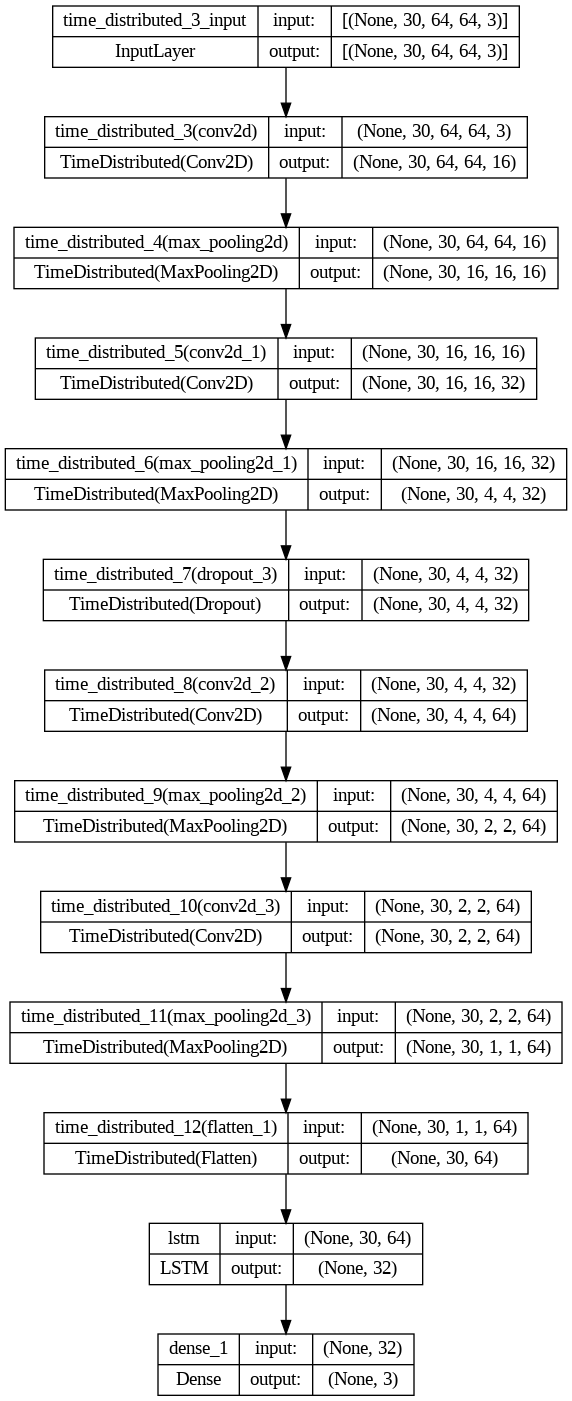

In [28]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [21]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 150, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 200, batch_size = 32,
                                             shuffle = True, validation_data = (features_test, labels_test),
                                             callbacks = [early_stopping_callback])

Epoch 1/200
5/5 [==============================] - 17s 466ms/step - loss: 1.1259 - accuracy: 0.3526 - val_loss: 1.1073 - val_accuracy: 0.1714
Epoch 2/200
5/5 [==============================] - 0s 74ms/step - loss: 1.0979 - accuracy: 0.3205 - val_loss: 1.1334 - val_accuracy: 0.4000
Epoch 3/200
5/5 [==============================] - 0s 72ms/step - loss: 1.0936 - accuracy: 0.3590 - val_loss: 1.1158 - val_accuracy: 0.3714
Epoch 4/200
5/5 [==============================] - 0s 71ms/step - loss: 1.0901 - accuracy: 0.4103 - val_loss: 1.0984 - val_accuracy: 0.2000
Epoch 5/200
5/5 [==============================] - 0s 73ms/step - loss: 1.0756 - accuracy: 0.4808 - val_loss: 1.0887 - val_accuracy: 0.1714
Epoch 6/200
5/5 [==============================] - 0s 74ms/step - loss: 1.0500 - accuracy: 0.5321 - val_loss: 1.0454 - val_accuracy: 0.5143
Epoch 7/200
5/5 [==============================] - 0s 74ms/step - loss: 0.9861 - accuracy: 0.5769 - val_loss: 0.9241 - val_accuracy: 0.6286
Epoch 8/200
5/5 [=

In [24]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 20ms/step - loss: 0.2308 - accuracy: 0.9714


### **Save the Model**

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [23]:
LRCN_model = load_model("LRCN_model___Date_Time_2023_08_24__14_57_04___Loss_0.515287458896637___Accuracy_0.800000011920929.h5")

In [43]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

  """
  This function will perform action recognition on a video using the LRCN model.
  Args:
  video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
  output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
  SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
  """

  # Initialize the VideoCapture object to read from the video file.
  video_reader = cv2.VideoCapture(video_file_path)

  # Get the Width and Height of the video.
  orignal_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  orignal_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Initialize the VideoWritter Object to store the output video in the disk.
  video_writer = cv2.VideoWriter(filename= output_file_path, fourcc= cv2.VideoWriter_fourcc("M", "P", "4", "V"),
                                 fps= video_reader.get(cv2.CAP_PROP_FPS), frameSize= (orignal_video_width, orignal_video_height))

  # Declare a queue to store video frames. (after apeended 30 frames, if we append new frame then starting frame will be delect)
  frames_queue = deque(maxlen= SEQUENCE_LENGTH)

  # Initialize a variable to store the predicted action being performed in the video.
  predicted_class_name = ""

  # Iterate until the video is accessed successfully.
  while video_reader.isOpened():

    # Read the frame.
    ret, frame = video_reader.read()

    # Check if frame is not read properly then break the loop.
    if not ret:
      break

    # Resize the Frame to fixed Dimensions.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame / 255

    # Appending the pre-processed frame into the frames list.
    frames_queue.append(normalized_frame)

    # Check if the number of frames in the queue are equal to the fixed sequence length.
    if len(frames_queue) == SEQUENCE_LENGTH:

      # Pass the normalized frames to the model and get the predicted probabilities.
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
      print("Frames Queue shape", len(frames_queue), np.expand_dims(frames_queue, axis=0).shape)

      # Get the index of class with highest probability
      predicted_label = np.argmax(predicted_labels_probabilities)

      if predicted_labels_probabilities[predicted_label] > 0.60:
        # Get the class name using the retrieved index.
        predicted_class_name = CLASSES_LIST[predicted_label]
        perc_accuracy = str(np.round(predicted_labels_probabilities[predicted_label], 2))

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, perc_accuracy, (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    # Write The frame into the disk using the VideoWriter Object.
    video_writer.write(frame)

  # Release the VideoCapture and VideoWriter objects.
  video_reader.release()
  video_writer.release()


In [44]:
fra_qu = deque(maxlen = 5)

for i in range(1,9):
  fra_qu.append(i)

print(fra_qu)

deque([4, 5, 6, 7, 8], maxlen=5)


In [45]:
# Construct the output video path.
output_video_file_path = f'outputs{SEQUENCE_LENGTH}.mp4'
input_video_file_path = os.path.join("/content/", "Lebanon_ Video Footage Shows Moment of Beirut Explosion.mp4")

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 23ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 24ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 23ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 23ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 31ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 23ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
Frames Queue shape 30 (1, 30, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
Frames Queue shape

In [ ]:
l = [0.23, 0.54, 0.98]
x = np.argmax(l)
l[x]

0.98

### **Create a Function To Perform a Single Prediction on Videos**

*  
Now let's create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.



In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
  """
  This function will perform single action recognition prediction on a video using the LRCN model.
  Args:
  video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
  SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
  """

  # Initialize the VideoCapture object to read from the video file.
  video_reader = cv2.VideoCapture(video_file_path)

  # Get the width and height of the video.
  orignal_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  orignal_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Declare a list to store video frames we will extract.
  frames_list = []

  # Initialize a variable to store the predicted action being performed in the video.
  predicted_class_name = ""

  # Get the number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

  # Iterating the number of times equal to the fixed length of sequence.
  for frame_counter in range(SEQUENCE_LENGTH):

    # Set the current frame position of the video.
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Read a frame.
    success, frame = video_reader.read()

    # Check if frame is not read properly then break the loop.
    if not success:
      break

    # Resize the Frame to fixed Dimensions.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame / 255

    # Appending the pre-processed frame into the frames list
    frames_list.append(normalized_frame)